In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-13 13:33:35 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-13 13:33:35 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-13 13:33:35 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-13 13:33:38 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-13 13:33:38 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-13 13:33:38 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-13 13:33:38 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-13 13:33:39 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-13 13:33:39 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-13 13:33:40 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-13 13:33:40 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-13 13:33:40 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-13 13:34:26 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-13 13:34:26 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-13 13:34:27 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from typing import Optional
from src.selection.data import SelectionSample
from src.tokens import prepare_input


from src.functional import (
    get_module_nnsight,
    PatchSpec,
    interpret_logits,
    patch_with_baukit,
)
from src.selection.utils import get_first_token_id

from src.utils.typing import TokenizerOutput
from src.attention import get_attention_matrices
from src.experiments.utils import verify_head_patterns


@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    query_locations: list[tuple[int, int, int]],  # (layer_idx, head_idx, query_idx)
    return_output: bool = False,
):
    layer_to_hq = {}
    for layer_idx, head_idx, query_idx in query_locations:
        if layer_idx not in layer_to_hq:
            layer_to_hq[layer_idx] = []
        layer_to_hq[layer_idx].append((head_idx, query_idx))

    q_projections = {}
    batch_size = input.input_ids.shape[0]
    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    head_dim = mt.n_embd // n_heads
    with mt.trace(input) as tracer:
        for layer_idx, query_locs in layer_to_hq.items():
            q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_proj_out = q_proj_module.output.view(
                batch_size, seq_len, n_heads, head_dim
            ).transpose(1, 2)
            for head_idx, query_idx in query_locs:
                q_projections[(layer_idx, head_idx, query_idx)] = (
                    q_proj_out[:, head_idx, query_idx, :].squeeze().save()
                )

        if return_output:
            output = mt.output.save()

    if return_output:
        return q_projections, output
    return q_projections


@torch.inference_mode()
def validate_q_proj_ie_on_sample_pair(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample,
    patch_sample: SelectionSample,
    heads: list[tuple[int, int]],
    query_indices: int = [-1],
    verify_head_behavior_on: Optional[int] = None,
):
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
    patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

    if verify_head_behavior_on is not None:
        logger.info("Verifying head behavior...")

        logger.info(f"Clean Sample >> Ans: {clean_sample.obj}")
        clean_attn_pattern = verify_head_patterns(
            prompt=clean_tokenized,
            options=clean_sample.options,
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
        )

        logger.info(f"Patch Sample >> Ans: {patch_sample.obj}")
        patch_attn_pattern = verify_head_patterns(
            prompt=patch_tokenized,
            options=patch_sample.options,
            pivot=patch_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
        )

    logger.info(f"Caching the query states for the {len(heads)} heads")

    query_locations = [
        (layer_idx, head_idx, query_idx)
        for layer_idx, head_idx in heads
        for query_idx in query_indices
    ]

    cached_q_states, patch_output = cache_q_projections(
        mt=mt,
        input=patch_tokenized,
        query_locations=query_locations,
        return_output=True,
    )
    q_proj_patches = []
    for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
        q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_idx,
                ),
                patch=q_proj,
            )
        )

    patch_logits = patch_output.logits[:, -1, :].squeeze()
    patch_predictions = interpret_logits(
        tokenizer=mt,
        logits=patch_logits,
    )
    logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")

    # interested_tokens = [
    #     patch_sample.ans_token_id,
    #     clean_sample.ans_token_id,
    #     clean_sample.metadata["track_type_obj_token_id"],
    # ]
    interested_tokens = clean_sample.options
    interested_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in interested_tokens
    ]
    interested_tokens += [patch_sample.ans_token_id]
    # interested_tokens = list(set(interested_tokens))  # remove duplicates #! don't need to, made sure during sampling

    logger.info("clean run")
    clean_output = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=[],
    )
    clean_logits = clean_output.logits[:, -1, :].squeeze()
    clean_predictions, clean_track = interpret_logits(
        tokenizer=mt,
        logits=clean_logits,
        interested_tokens=interested_tokens,
    )
    logger.info(f"clean_prediction={[str(pred) for pred in clean_predictions]}")
    logger.info(f"clean_track={clean_track}")

    logger.info("patching the q_proj states")
    if verify_head_behavior_on is not None:
        int_attn_pattern = verify_head_patterns(
            prompt=clean_tokenized,
            options=clean_sample.options,
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            query_patches=q_proj_patches,
            generate_full_answer=False,
            query_index=verify_head_behavior_on,
        )
        int_logits = int_attn_pattern["logits"].squeeze()

    else:
        int_out = patch_with_baukit(
            mt=mt,
            inputs=clean_tokenized,
            patches=q_proj_patches,
        )
        int_logits = int_out.logits[:, -1, :].squeeze()

    int_predictions, int_track = interpret_logits(
        tokenizer=mt,
        logits=int_logits,
        interested_tokens=interested_tokens,
    )
    logger.info(f"int_prediction={[str(pred) for pred in int_predictions]}")
    logger.info(f"int_track={int_track}")

    return {
        "clean_sample": clean_sample,
        "patch_sample": patch_sample,
        "clean_predictions": clean_predictions,
        "patch_predictions": patch_predictions,
        "int_predictions": int_predictions,
        "clean_track": clean_track,
        "int_track": int_track,
    }

## Loading the heads

### Attention Behavior

In [7]:
from scripts.locate_resolution_heads import SelectionSampleAttn
from tqdm import tqdm
attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns",
    "select_odd_one_out",
    mt.name.split("/")[-1],
    "objects"
)
files = sorted(os.listdir(attn_path))

#######################################################################
# LIMIT = 100
LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in tqdm(files[:LIMIT]):
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    # if len(selection_attns) % 10 == 0:
    #     print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:27<00:00,  5.71it/s]


500

In [8]:
from src.attention import visualize_attn_matrix

sample_idx = 18
# layer_idx = 39
# head_idx = 40
layer_idx = 35
head_idx = 19

selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(0.43115234375, 0.513671875, [0.0191650390625, 0.08251953125, 0.0291748046875, 0.00576019287109375, 0.0330810546875])


In [9]:
from tqdm.auto import tqdm

#############################################################################
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([64, 80])

2025-08-13 15:29:17 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fa0a6922310>


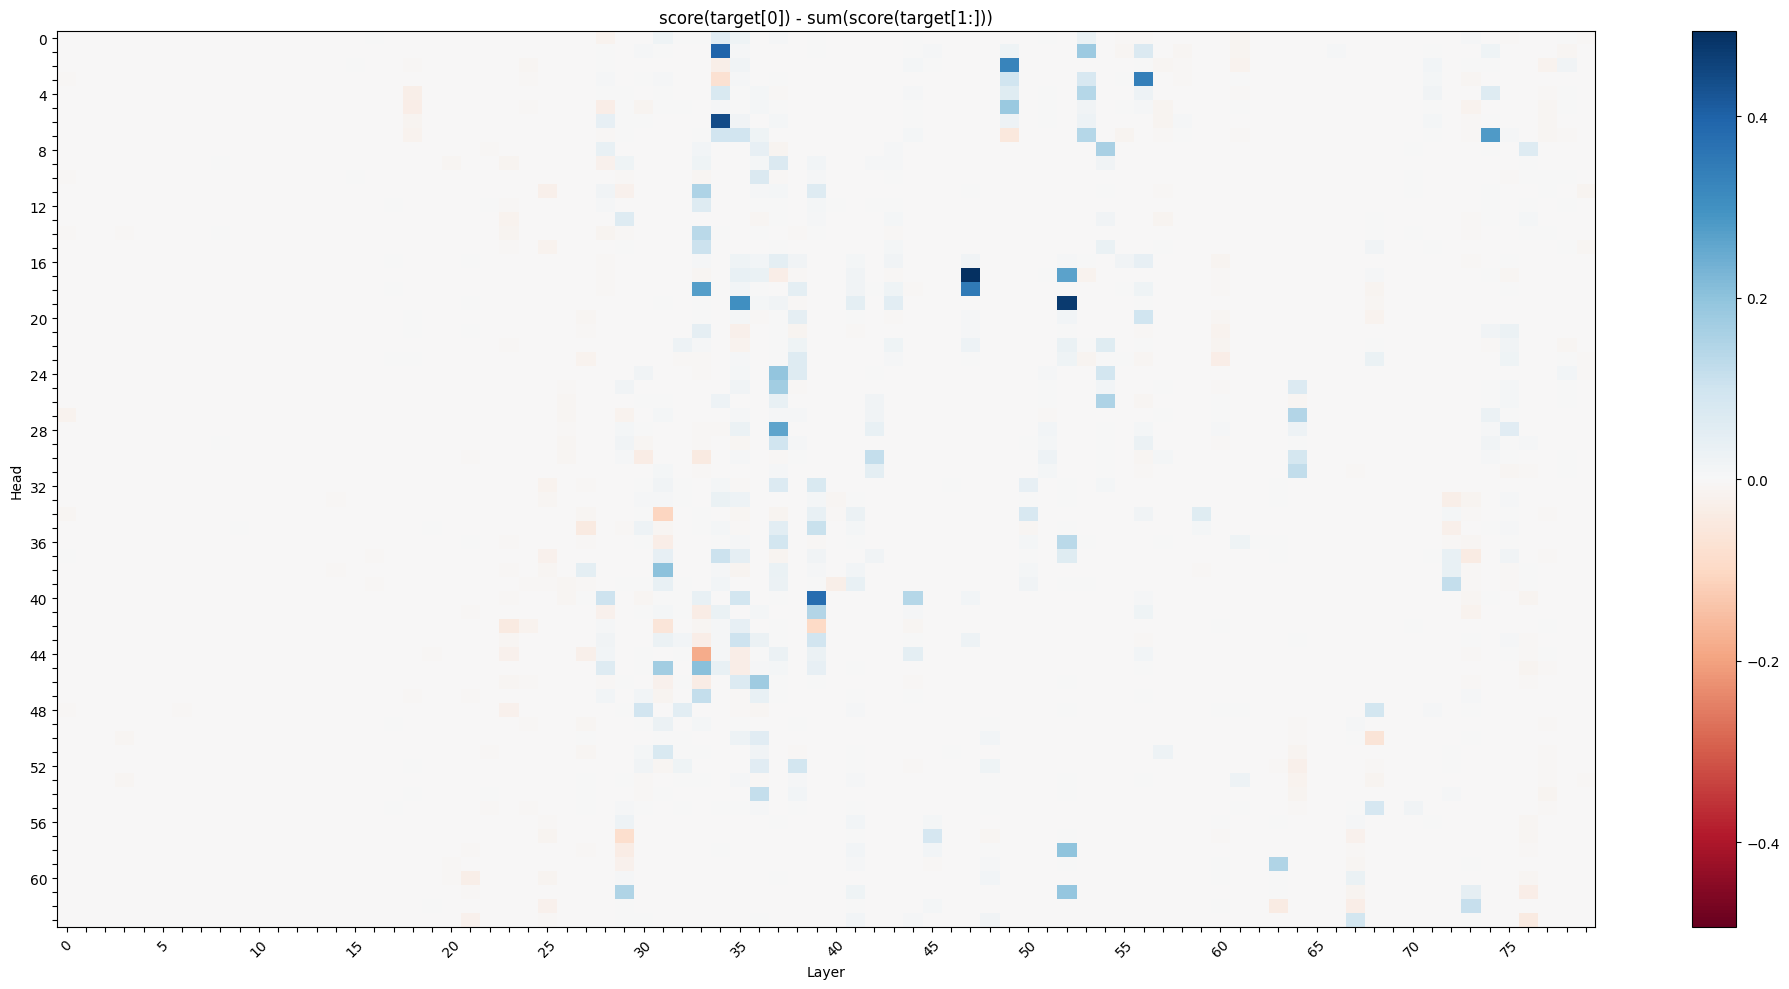

Layer 47, Head 17: 0.4938
Layer 52, Head 19: 0.4722
Layer 34, Head 6: 0.4414
Layer 34, Head 1: 0.3971
Layer 39, Head 40: 0.3761
Layer 47, Head 18: 0.3488
Layer 56, Head 3: 0.3390
Layer 49, Head 2: 0.3267
Layer 35, Head 19: 0.3034
Layer 74, Head 7: 0.2802
Layer 33, Head 18: 0.2732
Layer 52, Head 17: 0.2655
Layer 37, Head 28: 0.2613
Layer 33, Head 45: 0.2051
Layer 31, Head 38: 0.2024


In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [197]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:50]
# ]

# print(len(HEADS))

# HEADS = [(layer_idx, head_idx) for head_idx, layer_idx, score in scores_per_head[:10]]
HEADS = heads_selected
print(HEADS)

[(24, 3), (25, 32), (26, 25), (26, 26), (26, 30), (26, 39), (27, 17), (27, 34), (27, 35), (28, 0), (28, 2), (28, 9), (28, 20), (28, 31), (28, 41), (28, 45), (29, 8), (29, 11), (29, 12), (29, 25), (29, 58), (29, 61), (29, 62), (30, 24), (30, 28), (30, 48), (30, 53), (30, 54), (30, 57), (30, 62), (31, 7), (31, 32), (31, 34), (31, 36), (31, 37), (31, 38), (31, 39), (31, 41), (31, 43), (31, 47), (31, 49), (31, 51), (31, 52), (32, 0), (32, 2), (32, 12), (32, 19), (32, 21), (32, 23), (32, 48), (32, 52), (32, 57), (33, 11), (33, 15), (33, 18), (33, 21), (33, 23), (33, 30), (33, 41), (33, 42), (33, 44), (33, 45), (33, 46), (33, 47), (33, 48), (33, 49), (33, 53), (33, 54), (34, 1), (34, 2), (34, 3), (34, 4), (34, 6), (34, 7), (34, 17), (34, 23), (34, 26), (34, 35), (34, 36), (34, 37), (34, 38), (34, 41), (34, 43), (34, 45), (34, 46), (34, 55), (35, 0), (35, 4), (35, 6), (35, 7), (35, 17), (35, 18), (35, 19), (35, 20), (35, 21), (35, 22), (35, 23), (35, 24), (35, 27), (35, 28), (35, 29), (35, 33

## Utils

In [166]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.tokens import prepare_input
from src.selection.data import SelectOddOneOutTask

@torch.inference_mode()
def get_counterfactual_samples_odd_one_out(
    task: SelectOddOneOutTask,
    obj_category: str | None = None,
    distractor_category: str | None = None,
    prompt_template_idx=3,
    option_style="single_line",
    filter_by_lm_prediction: bool = True,
    n_distractors: int = 5,
    counterfact_obj_idx: int | None = None,
):
    patch_sample = task.get_random_sample(
        mt=mt,
        option_style=option_style,
        prompt_template_idx=prompt_template_idx,
        obj_category=obj_category,
        distractor_category=distractor_category,
        filter_by_lm_prediction=False,
        n_distractors=n_distractors,
        obj_idx = random.choice(list(set(list(range(n_distractors + 1))) - {0, 1}))
    )
    logger.info(f"patch_sample={str(patch_sample)}")

    #! criterion = not distractor_category
    # Options (2): 
    # 1. distractor_category (selected)
    # 2. category not in [obj_category, distractor_category] 
    not_dist_category_sample = task.get_random_sample(
        mt=mt,
        option_style=option_style,
        prompt_template_idx=prompt_template_idx,
        obj_category=distractor_category,
        distractor_category=random.choice(
            list(set(task.categories) - {obj_category, distractor_category})
        ),
        filter_by_lm_prediction=False,
        exclude_objs=patch_sample.options,
        n_distractors=1,
        obj_idx=counterfact_obj_idx
    )
    logger.info(f"not_dist_category_sample={str(not_dist_category_sample)}")
    track_idx = 1 ^ not_dist_category_sample.obj_idx
    not_dist_category_sample.metadata = {
        "track_type_obj": not_dist_category_sample.options[track_idx],
        "track_type_obj_idx": track_idx,
        "track_type_obj_token_id": get_first_token_id(
            not_dist_category_sample.options[track_idx], mt.tokenizer, prefix=" "
        ),
    }

    #! criterion = is obj_category
    # Options (2):
    # 1. obj_category
    # 2. category not in [obj_category, distractor_category] (selected)
    is_obj_category_sample = task.get_random_sample(
        mt=mt,
        option_style=option_style,
        prompt_template_idx=prompt_template_idx,
        distractor_category=obj_category,
        obj_category=random.choice(
            list(set(task.categories) - {obj_category, distractor_category})
        ),
        filter_by_lm_prediction=False,
        exclude_objs=patch_sample.options,
        n_distractors=1,
        obj_idx=counterfact_obj_idx
    )
    logger.info(f"is_obj_category_sample={str(is_obj_category_sample)}")
    track_idx = 1 ^ is_obj_category_sample.obj_idx
    is_obj_category_sample.metadata = {
        "track_type_obj_idx": track_idx,
        "track_type_obj": is_obj_category_sample.options[track_idx],
        "track_type_obj_category": obj_category,
        "track_type_obj_token_id": get_first_token_id(
            is_obj_category_sample.options[track_idx], mt.tokenizer, prefix=" "
        ),
    }

    if filter_by_lm_prediction:
        test_samples = [patch_sample, not_dist_category_sample, is_obj_category_sample]

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_odd_one_out(
                    task=task,
                    obj_category=obj_category,
                    distractor_category=distractor_category,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return {
        "patch_sample": patch_sample,
        "not_dist_category_sample": not_dist_category_sample,
        "is_obj_category_sample": is_obj_category_sample
    }

## Experiments

In [198]:
from src.selection.data import SelectOddOneOutTask

select_odd_one = SelectOddOneOutTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_odd_one)

SelectOddOneOutTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [199]:
#############################################
distractor_category="fruit"
obj_category="electronics"
option_style="single_line"
# option_style="numbered"
prompt_template_idx=3
N_DISTRACTORS = 5
counterfact_obj_idx = 1  # 0 or 1, if None, will be randomly selected
#############################################

In [200]:
exp_samples = get_counterfactual_samples_odd_one_out(
    task=select_odd_one,
    obj_category=obj_category,
    distractor_category=distractor_category,
    prompt_template_idx=prompt_template_idx,
    option_style=option_style,
    filter_by_lm_prediction=True,
    n_distractors=5
)

patch_sample = exp_samples["patch_sample"]
not_dist_category_sample = exp_samples["not_dist_category_sample"]
is_obj_category_sample = exp_samples["is_obj_category_sample"]

2025-08-13 17:48:48 __main__ INFO     patch_sample=Banana -> Phone (2): ['Pear', 'Watermelon', 'Phone', 'Strawberry', 'Orange', 'Plum']
2025-08-13 17:48:48 __main__ INFO     not_dist_category_sample=Sweater -> Cherry (1): ['Coat', 'Cherry']
2025-08-13 17:48:48 __main__ INFO     is_obj_category_sample=Smartwatch -> Willow (0): ['Willow', 'Headphones']
2025-08-13 17:48:48 __main__ INFO     Options: Pear, Watermelon, Phone, Strawberry, Orange, Plum.
Which among these objects mentioned above is not a fruit?
Answer:
2025-08-13 17:48:48 __main__ INFO     Banana | fruit -> Phone | pred=['" Phone"[14642] (p=0.832, logit=21.000)', '" The"[578] (p=0.068, logit=18.500)', '" A"[362] (p=0.025, logit=17.500)', '" Among"[22395] (p=0.017, logit=17.125)', '" “"[1054] (p=0.006, logit=16.000)']
2025-08-13 17:48:48 __main__ INFO     Options: Coat, Cherry.
Which among these objects mentioned above is not a clothing?
Answer:
2025-08-13 17:48:48 __main__ INFO     Sweater | clothing -> Cherry | pred=['" Cherr

In [201]:
print(patch_sample)
print(f'"{patch_sample.prompt()}"', ">>", patch_sample.obj)

Banana -> Phone (2): ['Pear', 'Watermelon', 'Phone', 'Strawberry', 'Orange', 'Plum']
"Options: Pear, Watermelon, Phone, Strawberry, Orange, Plum.
Which among these objects mentioned above is not a fruit?
Answer:" >> Phone


In [202]:
patch_attn_info = verify_head_patterns(
    prompt = patch_sample.prompt(),
    options = patch_sample.options,
    pivot = patch_sample.subj,
    mt = mt,
    heads = HEADS
)

not_dist_category_attn_info = verify_head_patterns(
    prompt = not_dist_category_sample.prompt(),
    options = not_dist_category_sample.options,
    pivot = not_dist_category_sample.subj,
    mt = mt,
    heads = HEADS
)

is_obj_category_attn_info = verify_head_patterns(
    prompt = is_obj_category_sample.prompt(),
    options = is_obj_category_sample.options,
    pivot = is_obj_category_sample.subj,
    mt = mt,
    heads = HEADS
)

0 patches to ablate possible answer information from options
2025-08-13 17:48:51 src.experiments.utils DEBUG    Predictions: ['" Phone"[14642] (p=0.832, logit=21.000)', '" The"[578] (p=0.068, logit=18.500)', '" A"[362] (p=0.025, logit=17.500)', '" Among"[22395] (p=0.017, logit=17.125)', '" “"[1054] (p=0.006, logit=16.000)']
2025-08-13 17:48:51 src.experiments.utils INFO     Combined attention matrix for all heads


0 patches to ablate possible answer information from options
2025-08-13 17:48:51 src.experiments.utils DEBUG    Predictions: ['" Cherry"[45805] (p=0.945, logit=21.000)', '" cherry"[41980] (p=0.022, logit=17.250)', '" ("[320] (p=0.006, logit=15.875)', '" The"[578] (p=0.004, logit=15.500)', '" Coat"[68867] (p=0.003, logit=15.312)']
2025-08-13 17:48:51 src.experiments.utils INFO     Combined attention matrix for all heads


0 patches to ablate possible answer information from options
2025-08-13 17:48:51 src.experiments.utils DEBUG    Predictions: ['" Willow"[65449] (p=0.918, logit=20.750)', '" ("[320] (p=0.012, logit=16.375)', '" The"[578] (p=0.012, logit=16.375)', '" Head"[11452] (p=0.010, logit=16.250)', '" will"[690] (p=0.009, logit=16.125)']
2025-08-13 17:48:51 src.experiments.utils INFO     Combined attention matrix for all heads


In [203]:
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
[mt.tokenizer.decode(patch_tokenized.input_ids[0][t]) for t in range(-3, 0)]

['?\n', 'Answer', ':']

In [204]:
not_dist_category_sample.metadata

{'track_type_obj': 'Coat',
 'track_type_obj_idx': 0,
 'track_type_obj_token_id': 68867,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  68867,     11,  45805,    627,  23956,   4315,
             1521,   6302,   9932,   3485,    374,    539,    264,  17895,   5380,
            16533,     25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
         device='cuda:0')}}

In [205]:
not_dist_category_patch = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=not_dist_category_sample,
    patch_sample=patch_sample,
    heads=HEADS,
    query_indices=[-3, -2, -1],
    verify_head_behavior_on=-1,
)

print("-" * 100)

clean_obj_tok = get_first_token_id(not_dist_category_sample.obj, tokenizer=mt.tokenizer, prefix=" ")
target_obj_tok = not_dist_category_sample.metadata["track_type_obj_token_id"]

before_clean = not_dist_category_patch["clean_track"][clean_obj_tok][1].logit
after_clean = not_dist_category_patch["int_track"][clean_obj_tok][1].logit
delta_clean = after_clean - before_clean
print(f"\"{mt.tokenizer.decode(clean_obj_tok)}\" |>> {before_clean=}, {after_clean=} | {delta_clean=}")

before_target = not_dist_category_patch["clean_track"][target_obj_tok][1].logit
after_target = not_dist_category_patch["int_track"][target_obj_tok][1].logit
delta_target = after_target - before_target
print(f"\"{mt.tokenizer.decode(target_obj_tok)}\" |>> {before_target=}, {after_target=} | {delta_target=}")

2025-08-13 17:49:21 __main__ INFO     Verifying head behavior...
2025-08-13 17:49:21 __main__ INFO     Clean Sample >> Ans: Cherry


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-13 17:49:24 src.experiments.utils DEBUG    Generated full answer: " Cherry. 
Explanation: Cherry is a fruit, not a clothing. Coat is a type of clothing. Therefore, Cherry is not a clothing. 
"
2025-08-13 17:49:24 src.experiments.utils DEBUG    Predictions: ['" Cherry"[45805] (p=0.945, logit=21.000)', '" cherry"[41980] (p=0.022, logit=17.250)', '" ("[320] (p=0.006, logit=15.875)', '" The"[578] (p=0.004, logit=15.500)', '" Coat"[68867] (p=0.003, logit=15.312)']
2025-08-13 17:49:24 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-13 17:49:25 __main__ INFO     Patch Sample >> Ans: Phone


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-13 17:49:28 src.experiments.utils DEBUG    Generated full answer: " Phone
Explanation: The given options are Pear, Watermelon, Phone, Strawberry, Orange, and Plum. Among these, Pear, Watermelon,"
2025-08-13 17:49:28 src.experiments.utils DEBUG    Predictions: ['" Phone"[14642] (p=0.832, logit=21.000)', '" The"[578] (p=0.068, logit=18.500)', '" A"[362] (p=0.025, logit=17.500)', '" Among"[22395] (p=0.017, logit=17.125)', '" “"[1054] (p=0.006, logit=16.000)']
2025-08-13 17:49:28 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-13 17:49:28 __main__ INFO     Caching the query states for the 261 heads
2025-08-13 17:49:29 __main__ INFO     patch_prediction=['" Phone"[14642] (p=0.832, logit=21.000)', '" The"[578] (p=0.068, logit=18.500)', '" A"[362] (p=0.025, logit=17.500)', '" Among"[22395] (p=0.017, logit=17.125)', '" “"[1054] (p=0.006, logit=16.000)']
2025-08-13 17:49:29 __main__ INFO     clean run
2025-08-13 17:49:29 __main__ INFO     clean_prediction=['" Cherry"[45805] (p=0.945, logit=21.000)', '" cherry"[41980] (p=0.022, logit=17.250)', '" ("[320] (p=0.006, logit=15.875)', '" The"[578] (p=0.004, logit=15.500)', '" Coat"[68867] (p=0.003, logit=15.312)']
2025-08-13 17:49:29 __main__ INFO     clean_track=OrderedDict([(45805, (1, PredictedToken(token=' Cherry', prob=0.9453125, logit=21.0, token_id=45805, metadata=None))), (68867, (5, PredictedToken(token=' Coat', prob=0.003204345703125, logit=15.3125, token_id=68867, metadata=None))), (14642, (207, PredictedToken(token=' Phone', prob=6.16908073425293e-0

2025-08-13 17:49:29 __main__ INFO     int_prediction=['" Coat"[68867] (p=0.326, logit=17.500)', '" None"[2290] (p=0.137, logit=16.625)', '" Jacket"[55870] (p=0.064, logit=15.875)', '" Object"[3075] (p=0.037, logit=15.312)', '" Objects"[25083] (p=0.034, logit=15.250)']
2025-08-13 17:49:29 __main__ INFO     int_track=OrderedDict([(68867, (1, PredictedToken(token=' Coat', prob=0.326171875, logit=17.5, token_id=68867, metadata=None))), (45805, (192, PredictedToken(token=' Cherry', prob=0.000102996826171875, logit=9.4375, token_id=45805, metadata=None))), (14642, (559, PredictedToken(token=' Phone', prob=1.5854835510253906e-05, logit=7.5625, token_id=14642, metadata=None)))])
----------------------------------------------------------------------------------------------------
" Cherry" |>> before_clean=21.0, after_clean=9.4375 | delta_clean=-11.5625
" Coat" |>> before_target=15.3125, after_target=17.5 | delta_target=2.1875


In [206]:
is_patch_cat_selection_patch = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=is_obj_category_sample,
    patch_sample=patch_sample,
    heads=HEADS,
    query_indices=[-3, -2, -1],
    verify_head_behavior_on=-1,
)

print("-" * 100)
clean_obj_tok = get_first_token_id(is_obj_category_sample.obj, tokenizer=mt.tokenizer, prefix=" ")
target_obj_tok = is_obj_category_sample.metadata["track_type_obj_token_id"]
before_clean = is_patch_cat_selection_patch["clean_track"][clean_obj_tok][1].logit
after_clean = is_patch_cat_selection_patch["int_track"][clean_obj_tok][1].logit
delta_clean = after_clean - before_clean
print(f"\"{mt.tokenizer.decode(clean_obj_tok)}\" |>> {before_clean=}, {after_clean=} | {delta_clean=}")

before_target = is_patch_cat_selection_patch["clean_track"][target_obj_tok][1].logit
after_target = is_patch_cat_selection_patch["int_track"][target_obj_tok][1].logit
delta_target = after_target - before_target
print(f"\"{mt.tokenizer.decode(target_obj_tok)}\" |>> {before_target=}, {after_target=} | {delta_target=}")

2025-08-13 17:49:58 __main__ INFO     Verifying head behavior...
2025-08-13 17:49:58 __main__ INFO     Clean Sample >> Ans: Willow


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-13 17:50:02 src.experiments.utils DEBUG    Generated full answer: " Willow
Explanation: Willow is a tree, and it is not an electronic device. Headphones, on the other hand, are an electronic device used"
2025-08-13 17:50:02 src.experiments.utils DEBUG    Predictions: ['" Willow"[65449] (p=0.918, logit=20.750)', '" ("[320] (p=0.012, logit=16.375)', '" The"[578] (p=0.012, logit=16.375)', '" Head"[11452] (p=0.010, logit=16.250)', '" will"[690] (p=0.009, logit=16.125)']
2025-08-13 17:50:02 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-13 17:50:02 __main__ INFO     Patch Sample >> Ans: Phone


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-13 17:50:06 src.experiments.utils DEBUG    Generated full answer: " Phone
Explanation: The given options are Pear, Watermelon, Phone, Strawberry, Orange, and Plum. Among these, Pear, Watermelon,"
2025-08-13 17:50:06 src.experiments.utils DEBUG    Predictions: ['" Phone"[14642] (p=0.832, logit=21.000)', '" The"[578] (p=0.068, logit=18.500)', '" A"[362] (p=0.025, logit=17.500)', '" Among"[22395] (p=0.017, logit=17.125)', '" “"[1054] (p=0.006, logit=16.000)']
2025-08-13 17:50:06 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-13 17:50:06 __main__ INFO     Caching the query states for the 261 heads
2025-08-13 17:50:07 __main__ INFO     patch_prediction=['" Phone"[14642] (p=0.832, logit=21.000)', '" The"[578] (p=0.068, logit=18.500)', '" A"[362] (p=0.025, logit=17.500)', '" Among"[22395] (p=0.017, logit=17.125)', '" “"[1054] (p=0.006, logit=16.000)']
2025-08-13 17:50:07 __main__ INFO     clean run
2025-08-13 17:50:07 __main__ INFO     clean_prediction=['" Willow"[65449] (p=0.918, logit=20.750)', '" The"[578] (p=0.012, logit=16.375)', '" ("[320] (p=0.012, logit=16.375)', '" Head"[11452] (p=0.010, logit=16.250)', '" will"[690] (p=0.009, logit=16.125)']
2025-08-13 17:50:07 __main__ INFO     clean_track=OrderedDict([(65449, (1, PredictedToken(token=' Willow', prob=0.91796875, logit=20.75, token_id=65449, metadata=None))), (11452, (4, PredictedToken(token=' Head', prob=0.01019287109375, logit=16.25, token_id=11452, metadata=None))), (14642, (113, PredictedToken(token=' Phone', prob=1.8477439880371094e-05, 

2025-08-13 17:50:07 __main__ INFO     int_prediction=['" Head"[11452] (p=0.918, logit=21.000)', '" headphones"[44101] (p=0.031, logit=17.625)', '" The"[578] (p=0.009, logit=16.375)', '" ("[320] (p=0.007, logit=16.125)', '" None"[2290] (p=0.003, logit=15.250)']
2025-08-13 17:50:07 __main__ INFO     int_track=OrderedDict([(11452, (1, PredictedToken(token=' Head', prob=0.91796875, logit=21.0, token_id=11452, metadata=None))), (14642, (106, PredictedToken(token=' Phone', prob=2.2292137145996094e-05, logit=10.375, token_id=14642, metadata=None))), (65449, (2386, PredictedToken(token=' Willow', prob=1.993030309677124e-07, logit=5.65625, token_id=65449, metadata=None)))])
----------------------------------------------------------------------------------------------------
" Willow" |>> before_clean=20.75, after_clean=5.65625 | delta_clean=-15.09375
" Head" |>> before_target=16.25, after_target=21.0 | delta_target=4.75


In [207]:
count_sample = SelectionSample(
    obj = "Banana",
    answer = "3",
    obj_idx = 3,
    # prompt_template="""<_options_>\nCount the number of fruits in the list\nAnswer:""",
    prompt_template="""Count the number of fruits in the following list:\n<_options_>\nAnswer:""",
    # prompt_template="""<_options_>\nAnswer:""",
    options=["Bus", "Apple", "Microphone", "Banana", "Orange", "Cow", "Table"],
    # default_option_style="numbered",
    # default_option_style="bullet",
)

print(count_sample.prompt())

validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=count_sample,
    patch_sample=patch_sample,
    heads=HEADS,
    query_indices=[-2, -1],
    verify_head_behavior_on=-1,
)

Count the number of fruits in the following list:
Options: Bus, Apple, Microphone, Banana, Orange, Cow, Table.
Answer:
2025-08-13 17:50:18 __main__ INFO     Verifying head behavior...
2025-08-13 17:50:18 __main__ INFO     Clean Sample >> Ans: Banana


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-13 17:50:22 src.experiments.utils DEBUG    Generated full answer: " There are 3 fruits in the list: Apple, Banana, and Orange.
This question requires the ability to identify and count the number of fruits in"
2025-08-13 17:50:22 src.experiments.utils DEBUG    Predictions: ['" There"[2684] (p=0.559, logit=21.500)', '" "[220] (p=0.264, logit=20.750)', '" The"[578] (p=0.085, logit=19.625)', '" Three"[14853] (p=0.046, logit=19.000)', '" We"[1226] (p=0.006, logit=17.000)']
2025-08-13 17:50:22 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-13 17:50:22 __main__ INFO     Patch Sample >> Ans: Phone


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-13 17:50:25 src.experiments.utils DEBUG    Generated full answer: " Phone
Explanation: The given options are Pear, Watermelon, Phone, Strawberry, Orange, and Plum. Among these, Pear, Watermelon,"
2025-08-13 17:50:26 src.experiments.utils DEBUG    Predictions: ['" Phone"[14642] (p=0.832, logit=21.000)', '" The"[578] (p=0.068, logit=18.500)', '" A"[362] (p=0.025, logit=17.500)', '" Among"[22395] (p=0.017, logit=17.125)', '" “"[1054] (p=0.006, logit=16.000)']
2025-08-13 17:50:26 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-13 17:50:26 __main__ INFO     Caching the query states for the 261 heads
2025-08-13 17:50:26 __main__ INFO     patch_prediction=['" Phone"[14642] (p=0.832, logit=21.000)', '" The"[578] (p=0.068, logit=18.500)', '" A"[362] (p=0.025, logit=17.500)', '" Among"[22395] (p=0.017, logit=17.125)', '" “"[1054] (p=0.006, logit=16.000)']
2025-08-13 17:50:26 __main__ INFO     clean run
2025-08-13 17:50:26 __main__ INFO     clean_prediction=['" There"[2684] (p=0.559, logit=21.500)', '" "[220] (p=0.264, logit=20.750)', '" The"[578] (p=0.085, logit=19.625)', '" Three"[14853] (p=0.046, logit=19.000)', '" We"[1226] (p=0.006, logit=17.000)']
2025-08-13 17:50:26 __main__ INFO     clean_track=OrderedDict([(8325, (8, PredictedToken(token=' Apple', prob=0.0025787353515625, logit=16.125, token_id=8325, metadata=None))), (19111, (34, PredictedToken(token=' Bus', prob=0.0003490447998046875, logit=14.125, token_id=19111, metadata=None))), (76924, (58, PredictedToken(token=' Banana', prob=0.0001134872436

2025-08-13 17:50:27 __main__ INFO     int_prediction=['" There"[2684] (p=0.490, logit=21.125)', '" "[220] (p=0.231, logit=20.375)', '" The"[578] (p=0.109, logit=19.625)', '" Only"[8442] (p=0.028, logit=18.250)', '" In"[763] (p=0.028, logit=18.250)']
2025-08-13 17:50:27 __main__ INFO     int_track=OrderedDict([(19111, (10, PredictedToken(token=' Bus', prob=0.006988525390625, logit=16.875, token_id=19111, metadata=None))), (6771, (226, PredictedToken(token=' Table', prob=8.165836334228516e-06, logit=10.125, token_id=6771, metadata=None))), (8325, (233, PredictedToken(token=' Apple', prob=7.68899917602539e-06, logit=10.0625, token_id=8325, metadata=None))), (18654, (249, PredictedToken(token=' Micro', prob=6.377696990966797e-06, logit=9.875, token_id=18654, metadata=None))), (22607, (403, PredictedToken(token=' Cow', prob=2.652406692504883e-06, logit=9.0, token_id=22607, metadata=None))), (14642, (594, PredictedToken(token=' Phone', prob=1.3336539268493652e-06, logit=8.3125, token_id=1464

{'clean_sample': SelectionSample(obj='Banana', answer='3', obj_idx=3, prompt_template='Count the number of fruits in the following list:\n<_options_>\nAnswer:', options=['Bus', 'Apple', 'Microphone', 'Banana', 'Orange', 'Cow', 'Table'], subj=None, category=None, prediction=None, ans_token_id=None, metadata={}, default_option_style='single_line'),
 'patch_sample': SelectionSample(obj='Phone', answer='Phone', obj_idx=2, prompt_template='<_options_>\nWhich among these objects mentioned above is not a <_category_>?\nAnswer:', options=['Pear', 'Watermelon', 'Phone', 'Strawberry', 'Orange', 'Plum'], subj='Banana', category='fruit', prediction=[PredictedToken(token=' Phone', prob=0.83203125, logit=21.0, token_id=14642, metadata=None), PredictedToken(token=' The', prob=0.068359375, logit=18.5, token_id=578, metadata=None), PredictedToken(token=' A', prob=0.025146484375, logit=17.5, token_id=362, metadata=None), PredictedToken(token=' Among', prob=0.0172119140625, logit=17.125, token_id=22395, 

### Search for heads with the most patching effect

In [145]:
from itertools import product
from src.functional import patch_with_baukit, interpret_logits

all_heads = list(product(range(30, 50), range(mt.config.num_attention_heads)))
query_indices = [-3, -2, -1]  # last 3 tokens
query_locations = [
    (layer_idx, head_idx, query_idx)
    for layer_idx, head_idx in all_heads
    for query_idx in query_indices
]

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
cached_q_states, patch_output = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    return_output=True,
)

patch_logits = patch_output.logits[:, -1, :].squeeze()
interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
)

[PredictedToken(token=' Router', prob=0.81640625, logit=20.25, token_id=10777, metadata=None),
 PredictedToken(token=' The', prob=0.05908203125, logit=17.625, token_id=578, metadata=None),
 PredictedToken(token=' A', prob=0.021728515625, logit=16.625, token_id=362, metadata=None),
 PredictedToken(token=' Among', prob=0.0169677734375, logit=16.375, token_id=22395, metadata=None),
 PredictedToken(token=' It', prob=0.009033203125, logit=15.75, token_id=1102, metadata=None)]

In [146]:
clean_sample_type = {
    "not_dist_category": not_dist_category_sample,
    "is_obj_category": is_obj_category_sample,
}

base_scores = {}

for sample_type, clean_sample in clean_sample_type.items():
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
    clean_sample.metadata["tokenized"] = clean_tokenized.data

    clean_out = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=[],
    )
    base_logits = clean_out.logits[:, -1, :].squeeze()
    base_predictions, base_track = interpret_logits(
        tokenizer=mt,
        logits=base_logits,
        interested_tokens=[
            get_first_token_id(clean_sample.obj, tokenizer=mt.tokenizer, prefix=" "),
            clean_sample.metadata["track_obj_token_id"],
        ],
    )
    print(base_track[clean_sample.metadata["track_obj_token_id"]])
    base_scores[sample_type] = base_track[clean_sample.metadata["track_obj_token_id"]]

(4, PredictedToken(token=' R', prob=0.0115966796875, logit=16.125, token_id=432, metadata=None))
(3, PredictedToken(token=' Mouse', prob=0.05615234375, logit=17.375, token_id=18191, metadata=None))


In [147]:
base_scores

{'not_dist_category': (4,
  PredictedToken(token=' R', prob=0.0115966796875, logit=16.125, token_id=432, metadata=None)),
 'is_obj_category': (3,
  PredictedToken(token=' Mouse', prob=0.05615234375, logit=17.375, token_id=18191, metadata=None))}

In [148]:
q_proj_patches = []
for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_idx,
            ),
            patch=q_proj,
        )
    )

int_scores = {}
for sample_type, clean_sample in clean_sample_type.items():
    clean_tokenized = TokenizerOutput(data=clean_sample.metadata["tokenized"])

    int_out = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=q_proj_patches,
    )
    int_logits = int_out.logits[:, -1, :].squeeze()
    int_predictions, int_track = interpret_logits(
        tokenizer=mt,
        logits=int_logits,
        interested_tokens=[
            get_first_token_id(clean_sample.obj, tokenizer=mt.tokenizer, prefix=" "),
            clean_sample.metadata["track_obj_token_id"],
        ],
    )
    print(int_track[clean_sample.metadata["track_obj_token_id"]])
    int_scores[sample_type] = int_track[clean_sample.metadata["track_obj_token_id"]]

(2, PredictedToken(token=' R', prob=0.24609375, logit=17.25, token_id=432, metadata=None))
(2, PredictedToken(token=' Mouse', prob=0.314453125, logit=19.125, token_id=18191, metadata=None))


In [149]:
individual_patching_effects = {
    "not_dist_category": {},
    "is_obj_category": {},
}
print(query_indices)
for layer_idx, head_idx in tqdm(all_heads, desc="Iterating over heads"):
    q_proj_patches = [
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_idx,
            ),
            patch= cached_q_states[(layer_idx, head_idx, query_idx)],
        ) for query_idx in query_indices
    ]
    for sample_type, clean_sample in clean_sample_type.items():
        clean_tokenized = TokenizerOutput(data=clean_sample.metadata["tokenized"])

        # Patch the q_proj for the current head
        out = patch_with_baukit(
            mt=mt,
            inputs=clean_tokenized,
            patches=q_proj_patches,
        )
        logits = out.logits[:, -1, :].squeeze()
        target_tok = clean_sample.metadata["track_obj_token_id"]
        predictions, track = interpret_logits(
            tokenizer=mt,
            logits=logits,
            interested_tokens=[target_tok],
        )
        individual_patching_effects[sample_type][
            (layer_idx, head_idx)
        ] = track

[-3, -2, -1]


Iterating over heads:   0%|          | 0/1280 [00:00<?, ?it/s]

In [151]:
not_dist_category_sample.metadata

{'track_idx': 0,
 'track_obj': 'Racket',
 'track_obj_category': 'fruit',
 'track_obj_token_id': 432,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,    432,   5827,     11,  45805,    627,  23956,
             4315,   1521,   6302,   9932,   3485,    374,    539,    264,  10775,
             7241,   5380,  16533,     25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
         device='cuda:0')},
 'pred_track': OrderedDict([(45805,
               (1,
                PredictedToken(token=' Cherry', prob=0.91796875, logit=20.5, token_id=45805, metadata=None))),
              (432,
               (4,
                PredictedToken(token=' R', prob=0.0115966796875, logit=16.125, token_id=432, metadata=None)))])}

In [159]:
from scripts.patching_within_task import SelectionQprojPatchResult

not_dist_category_headwise_ie = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=not_dist_category_sample,
    interested_tokens=[not_dist_category_sample.metadata["track_obj_token_id"]],
    base_results=base_scores["not_dist_category"],
    headwise_patching_effects=individual_patching_effects["not_dist_category"],
)

is_obj_category_headwise_ie = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=is_obj_category_sample,
    interested_tokens=[is_obj_category_sample.metadata["track_obj_token_id"]],
    base_results=base_scores["is_obj_category"],
    headwise_patching_effects=individual_patching_effects["is_obj_category"],
)

In [165]:
patching_results = not_dist_category_headwise_ie
patching_results = is_obj_category_headwise_ie

headwise_scores = [
    (
        layer_idx,
        head_idx,
        patching_results.head_effect(layer_idx, head_idx)
    )
    for layer_idx, head_idx in patching_results.headwise_patching_effects.keys()
]

headwise_scores = sorted(headwise_scores, key=lambda x: x[2], reverse=True)
patching_heads = []
for layer_idx, head_idx, score in headwise_scores[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")
    patching_heads.append((layer_idx, head_idx))

Layer 33, Head 44: 0.6250
Layer 33, Head 45: 0.3750
Layer 31, Head 36: 0.2500
Layer 32, Head 23: 0.2500
Layer 30, Head 11: 0.1250
Layer 30, Head 39: 0.1250
Layer 30, Head 48: 0.1250
Layer 30, Head 54: 0.1250
Layer 30, Head 55: 0.1250
Layer 30, Head 60: 0.1250
Layer 31, Head 24: 0.1250
Layer 31, Head 38: 0.1250
Layer 31, Head 45: 0.1250
Layer 31, Head 47: 0.1250
Layer 31, Head 50: 0.1250


## Optimization to select heads to patch

In [228]:
from torch.optim import AdamW
from src.utils.typing import TokenizerOutput
from src.functional import free_gpu_cache
import baukit


def get_optimal_head_mask(
    mt: ModelandTokenizer,
    train_set: list[tuple[SelectionSample, SelectionSample]],
    learning_rate: float = 1e-3,
    n_epochs: int = 5,
    lamb: float = 1e-3,
    batch_size: int = 4,
    query_indices: int = [-1],
):
    hparams = {
        "learning_rate": learning_rate,
        "n_epochs": n_epochs,
        "lamb": lamb,
        "batch_size": batch_size,
    }
    logger.debug(f"Training with hparams: {hparams}")
    n_layer = mt.n_layer
    n_heads = mt.config.num_attention_heads

    mask = torch.ones(
        (n_layer, n_heads), dtype=mt.dtype, requires_grad=True, device=mt.device
    )

    # prompts = []
    # prompts.extend([sample.prompt() for sample in clean_samples])
    # prompts.extend([sample.prompt() for sample in patch_samples])
    # tokenized = prepare_input(prompts=prompts, tokenizer=mt)

    # clean_tokenized = TokenizerOutput(data = {k: v[:len(clean_samples), :] for k, v in tokenized.items()})
    # patch_tokenized = TokenizerOutput(data = {k: v[len(clean_samples):, :] for k, v in tokenized.items()})

    optimizer = AdamW([mask], lr=learning_rate)
    losses = []

    all_heads = [
        (layer_idx, head_idx)
        for layer_idx in range(n_layer)
        for head_idx in range(n_heads)
    ]
    all_q_proj_modules = [
        mt.attn_module_name_format.format(layer_idx) + ".q_proj"
        for layer_idx in range(n_layer)
    ]
    batches = []
    for batch_start in range(0, len(train_set), batch_size):
        batches.append(train_set[batch_start : batch_start + batch_size])

    query_locations = [
        (layer_idx, head_idx, query_idx)
        for layer_idx, head_idx in all_heads
        for query_idx in query_indices
    ]

    logger.info("Caching q projections from patch samples...")
    q_projections_from_patch_samples = {}
    for batch_idx, batch in enumerate(batches):
        clean_samples, patch_samples = zip(*batch)
        prompts = []
        prompts.extend([sample.prompt() for sample in clean_samples])
        prompts.extend([sample.prompt() for sample in patch_samples])
        tokenized = prepare_input(prompts=prompts, tokenizer=mt)
        # clean_tokenized = TokenizerOutput(data = {k: v[:len(clean_samples), :] for k, v in tokenized.items()})
        patch_tokenized = TokenizerOutput(
            data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
        )

        q_projections = cache_q_projections(
            mt=mt,
            input=patch_tokenized,
            query_locations=query_locations,
            return_output=False,
        )

        patches = {}
        for (layer_idx, head_idx, query_idx), q_proj in q_projections.items():
            module_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            patches[(module_name, head_idx)] = (layer_idx, q_proj)
        q_projections_from_patch_samples[batch_idx] = patches
        logger.info(f"Caching completed > {batch_idx+1}/{len(batches)} batches.")
        free_gpu_cache()

    logger.info("Starting training...")

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(batches):
            optimizer.zero_grad()

            batch_size_actual = len(batch)

            clean_samples, patch_samples = zip(*batch)
            prompts = []
            prompts.extend([sample.prompt() for sample in clean_samples])
            prompts.extend([sample.prompt() for sample in patch_samples])
            tokenized = prepare_input(prompts=prompts, tokenizer=mt)
            clean_tokenized = TokenizerOutput(
                data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
            )
            patch_tokenized = TokenizerOutput(
                data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
            )
            batch_target_tokens = [
                clean_sample.metadata["track_type_obj_token_id"]
                for clean_sample in clean_samples
            ]
            batch_distractor_tokens = [
                [
                    get_first_token_id(tokenizer=mt.tokenizer, name=option, prefix=" ")
                    for idx, option in enumerate(clean_sample.options)
                    if idx != clean_sample.metadata["track_type_obj_idx"]
                ]
                for clean_sample in clean_samples
            ]

            patch_q_states = q_projections_from_patch_samples[batch_idx]

            batch_size = clean_tokenized.input_ids.shape[0]
            seq_len = clean_tokenized.input_ids.shape[1]
            head_dim = mt.n_embd // n_heads

            def perform_patch(repr, layer_name):
                if layer_name not in all_q_proj_modules:
                    return repr

                repr = repr.view(batch_size, seq_len, n_heads, head_dim).transpose(1, 2)
                for head_idx in range(n_heads):
                    q_clean = repr[:, head_idx, query_idx, :]
                    layer_idx, q_patch = patch_q_states[(layer_name, head_idx)]
                    q_patch = q_patch.clone().to(q_clean.dtype).to(q_clean.device)
                    q_patch.requires_grad = True
                    coeff = (
                        mask[layer_idx, head_idx].to(q_clean.dtype).to(q_clean.device)
                    )
                    # head_patch = coeff * q_patch + (1 - coeff) * q_clean
                    repr[:, head_idx, query_idx, :] += coeff * (q_patch - q_clean)

                repr = repr.transpose(1, 2).view(
                    batch_size, seq_len, n_heads * head_dim
                )
                return repr

            with baukit.TraceDict(
                module=mt._model, layers=all_q_proj_modules, edit_output=perform_patch
            ):
                output = mt._model(**clean_tokenized)

            logits = output.logits[:, -1, :]

            # calculate target loss
            target_logits = [
                logit[tok] for logit, tok in zip(logits, batch_target_tokens)
            ]
            target_loss = -torch.stack(target_logits).mean()  # need this to go up

            # calculate distractor loss
            distractor_logits = [
                logit[distractor_tokens].mean()
                for logit, distractor_tokens in zip(logits, batch_distractor_tokens)
            ]
            distractor_loss = torch.stack(distractor_logits).mean()

            # mask_loss
            mask_l1_loss = torch.abs(mask).sum() * lamb
            loss = target_loss + distractor_loss + mask_l1_loss
            logger.debug(
                f"Epoch={epoch+1} | {batch_idx=} |>> {target_loss.item():.4f} + {distractor_loss.item():.4f} + {mask_l1_loss.item():.4f} = {loss.item():.4f}"
            )

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                mask.clamp_(0, 1)
                mask += 1e-4  # to avoid zero gradients

            epoch_loss += loss.item() * batch_size_actual
            losses.append(loss.item())

        epoch_loss /= len(train_set)
        logger.info(f"Epoch {epoch+1}/{n_epochs} completed. Avg Loss: {epoch_loss:.4f}")
        mt._model.zero_grad()
        free_gpu_cache()
    

    mt._model.zero_grad()
    with torch.no_grad():
        mask.clamp_(0, 1)

    free_gpu_cache()
    return mask.detach().cpu(), losses

In [229]:
# print(clean_sample.prompt(), ">>", clean_sample.obj)
# print(patch_sample.prompt(), ">>", patch_sample.obj)

# train_set = [(clean_sample, patch_sample)]


In [ ]:
free_gpu_cache()
train_set = []
train_limit = 512

while len(train_set) < train_limit:
    samples = get_counterfactual_samples_odd_one_out(
        task=select_odd_one,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style="single_line",
        n_distractors=5
    )
    train_set.append(samples)

2025-08-13 17:51:13 __main__ INFO     patch_sample=Desk -> Hospital (3): ['Table', 'Stool', 'Dresser', 'Hospital', 'Bench', 'Ottoman']
2025-08-13 17:51:13 __main__ INFO     not_dist_category_sample=Cow -> Broccoli (1): ['Horse', 'Broccoli']
2025-08-13 17:51:13 __main__ INFO     is_obj_category_sample=Magnolia -> Accordion (1): ['Bamboo', 'Accordion']
2025-08-13 17:51:13 __main__ INFO     Options: Table, Stool, Dresser, Hospital, Bench, Ottoman.
Which among these objects mentioned above is not a furniture?
Answer:
2025-08-13 17:51:13 __main__ INFO     Desk | furniture -> Hospital | pred=['" Hospital"[15429] (p=0.945, logit=22.250)', '" The"[578] (p=0.010, logit=17.750)', '" A"[362] (p=0.008, logit=17.500)', '" H"[473] (p=0.004, logit=16.875)', '" “"[1054] (p=0.004, logit=16.750)']
2025-08-13 17:51:13 __main__ INFO     Options: Horse, Broccoli.
Which among these objects mentioned above is not a animal?
Answer:
2025-08-13 17:51:13 __main__ INFO     Cow | animal -> Broccoli | pred=['" Bro"

In [230]:
mt._model.zero_grad()
free_gpu_cache()

In [231]:
free_gpu_cache()
optimal_mask, losses = get_optimal_head_mask(
    mt=mt,
    train_set=[
        (samples["not_dist_category_sample"], samples["patch_sample"])
        for samples in train_set
    ],
    learning_rate=1e-2,
    n_epochs=20,
    lamb=2e-2,
    batch_size=16,
    query_indices=[-3, -2, -1],
)

2025-08-13 18:10:19 __main__ DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 20, 'lamb': 0.02, 'batch_size': 16}
2025-08-13 18:10:19 __main__ INFO     Caching q projections from patch samples...
2025-08-13 18:10:28 __main__ INFO     Caching completed > 1/32 batches.
2025-08-13 18:10:42 __main__ INFO     Caching completed > 2/32 batches.
2025-08-13 18:10:57 __main__ INFO     Caching completed > 3/32 batches.
2025-08-13 18:11:12 __main__ INFO     Caching completed > 4/32 batches.
2025-08-13 18:11:27 __main__ INFO     Caching completed > 5/32 batches.
2025-08-13 18:11:42 __main__ INFO     Caching completed > 6/32 batches.
2025-08-13 18:11:57 __main__ INFO     Caching completed > 7/32 batches.
2025-08-13 18:12:12 __main__ INFO     Caching completed > 8/32 batches.
2025-08-13 18:12:28 __main__ INFO     Caching completed > 9/32 batches.
2025-08-13 18:12:43 __main__ INFO     Caching completed > 10/32 batches.
2025-08-13 18:12:59 __main__ INFO     Caching completed > 11/32 

In [232]:
import numpy as np

np.savez_compressed("optimized_heads_odd_one_out.npz", **dict(
    optimal_mask=optimal_mask.to(torch.float32).numpy(),
    losses=np.array(losses, dtype=np.float32)
), allow_pickle=True)

In [233]:
optimzation_results = np.load("optimized_heads_odd_one_out.npz", allow_pickle=True)

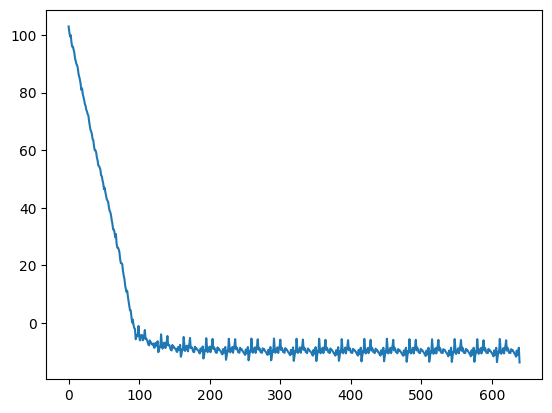

In [234]:
from matplotlib import pyplot as plt
plt.plot(optimzation_results["losses"])

In [235]:
optimzation_results["optimal_mask"].shape

(80, 64)

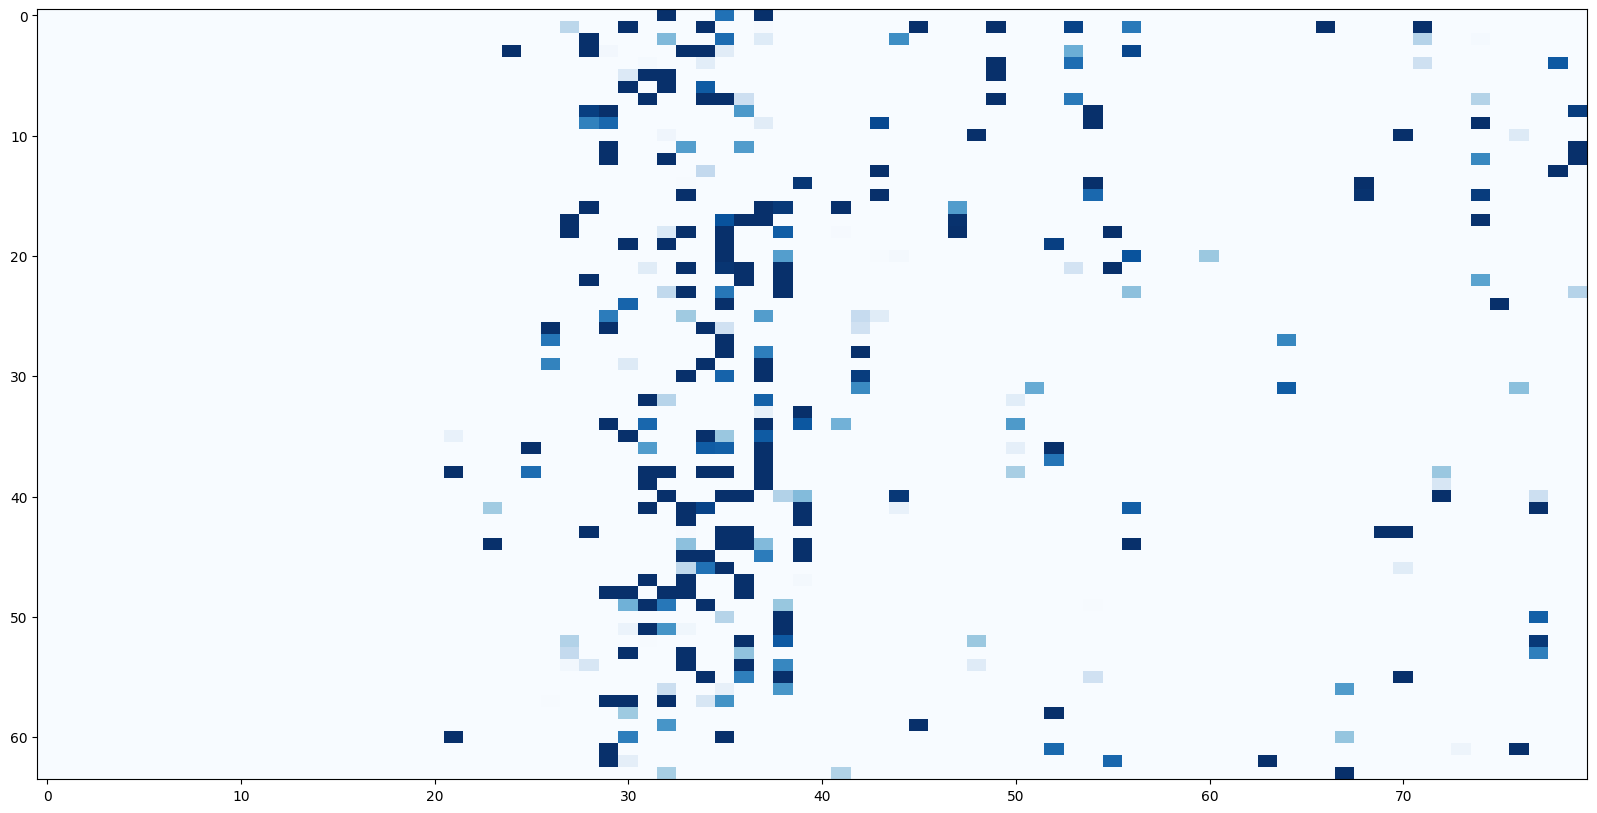

In [236]:
plt.figure(figsize=(20, 10))
plt.imshow(
    # optimal_mask.round().T.to(torch.float32).numpy(),
    torch.tensor(optimzation_results["optimal_mask"]).T.to(torch.float32).numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

In [195]:
heads_selected = torch.nonzero(optimal_mask > 0.5, as_tuple=False).tolist()
heads_selected = [(layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 60]
len(heads_selected)

261

## Validation of the patching effect

In [60]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 200

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style="single_line",
        distinct_options=True,
    )
    validation_set.append((clean, patch))

2025-08-12 13:24:03 __main__ INFO     Patch category: animal, subject: Cat, object: Lion
2025-08-12 13:24:03 __main__ INFO     Clean category: vegetable, subject: Tomato, object: Mushroom
2025-08-12 13:24:03 __main__ INFO     patch_must_have_options=['Lion', 'Potato']
2025-08-12 13:24:03 __main__ INFO     clean_must_have_options=['Mushroom', 'Zebra']
2025-08-12 13:24:03 __main__ INFO     clean_type_obj='Potato'
2025-08-12 13:24:03 __main__ INFO     patch_type_obj='Zebra'
2025-08-12 13:24:03 __main__ INFO     patch_obj_idx=1 | ['Potato', 'Lion', 'Pen', 'Theater', 'Pear', 'Maple']
2025-08-12 13:24:03 __main__ INFO     clean_obj_idx=3 | ['Zebra', 'Flute', 'Train', 'Mushroom', 'Rose', 'Paper']
2025-08-12 13:24:03 __main__ INFO     Options: Potato, Lion, Pen, Theater, Pear, Maple.
Which among these objects mentioned above is a animal?
Answer:
2025-08-12 13:24:03 __main__ INFO     Cat | animal -> Lion | pred=['" Lion"[33199] (p=0.719, logit=21.250)', '" The"[578] (p=0.110, logit=19.375)', '"

In [146]:
print(clean_sample.prompt(), ">>", clean_sample.obj)

Options: Zebra, Bathtub, Yoga mat, Lettuce, Hat, Mango.
Which among these objects mentioned above is a fruit?
Answer: >> Mango


In [147]:
# mt.tokenizer.decode(clean_sample.obj_token_id)
mt.tokenizer.decode(clean_sample.metadata["track_type_obj_token_id"])

' Bat'

In [164]:
from typing import Optional

from src.functional import (
    get_module_nnsight,
    PatchSpec,
    interpret_logits,
    patch_with_baukit,
)
from src.selection.utils import get_first_token_id


@torch.inference_mode()
def validate_q_proj_ie_on_sample_pair(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample,
    patch_sample: SelectionSample,
    heads: list[tuple[int, int]],
    query_indices: int = [-1],
    verify_head_behavior_on: Optional[int] = None,
):
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
    patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

    if verify_head_behavior_on is not None:
        logger.info("Verifying head behavior...")

        logger.info(f"Clean Sample >> Ans: {clean_sample.obj}")
        clean_attn_pattern = verify_head_patterns(
            prompt=clean_tokenized,
            options=clean_sample.options,
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
        )

        logger.info(f"Patch Sample >> Ans: {patch_sample.obj}")
        patch_attn_pattern = verify_head_patterns(
            prompt=patch_tokenized,
            options=patch_sample.options,
            pivot=patch_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
        )

    logger.info(f"Caching the query states for the {len(heads)} heads")

    query_locations = [
        (layer_idx, head_idx, query_idx)
        for layer_idx, head_idx in heads
        for query_idx in query_indices
    ]

    cached_q_states, patch_output = cache_q_projections(
        mt=mt,
        input=patch_tokenized,
        query_locations=query_locations,
        return_output=True,
    )
    q_proj_patches = []
    for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
        q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_idx,
                ),
                patch=q_proj,
            )
        )

    patch_logits = patch_output.logits[:, -1, :].squeeze()
    patch_predictions = interpret_logits(
        tokenizer=mt,
        logits=patch_logits,
    )
    logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")

    # interested_tokens = [
    #     patch_sample.ans_token_id,
    #     clean_sample.ans_token_id,
    #     clean_sample.metadata["track_type_obj_token_id"],
    # ]
    interested_tokens = clean_sample.options
    interested_tokens = [get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ") for opt in interested_tokens]
    interested_tokens += [patch_sample.ans_token_id]
    # interested_tokens = list(set(interested_tokens))  # remove duplicates #! don't need to, made sure during sampling

    logger.info("clean run")
    clean_output = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=[],
    )
    clean_logits = clean_output.logits[:, -1, :].squeeze()
    clean_predictions, clean_track = interpret_logits(
        tokenizer=mt,
        logits=clean_logits,
        interested_tokens=interested_tokens,
    )
    logger.info(f"clean_prediction={[str(pred) for pred in clean_predictions]}")
    logger.info(f"clean_track={clean_track}")

    logger.info("patching the q_proj states")
    if verify_head_behavior_on is not None:
        int_attn_pattern = verify_head_patterns(
            prompt=clean_tokenized,
            options=clean_sample.options,
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            query_patches=q_proj_patches,
            generate_full_answer=False,
            query_index=verify_head_behavior_on,
        )
        int_logits = int_attn_pattern["logits"].squeeze()

    else:
        int_out = patch_with_baukit(
            mt=mt,
            inputs=clean_tokenized,
            patches=q_proj_patches,
        )
        int_logits = int_out.logits[:, -1, :].squeeze()

    int_predictions, int_track = interpret_logits(
        tokenizer=mt,
        logits=int_logits,
        interested_tokens=interested_tokens,
    )
    logger.info(f"int_prediction={[str(pred) for pred in int_predictions]}")
    logger.info(f"int_track={int_track}")

    return {
        "clean_sample": clean_sample,
        "patch_sample": patch_sample,
        "clean_predictions": clean_predictions,
        "patch_predictions": patch_predictions,
        "int_predictions": int_predictions,
        "clean_track": clean_track,
        "int_track": int_track,
    }


# clean, patch = validation_set[25]
# clean, patch = clean_sample, patch_sample
failed_case = failed_cases[0]
clean = failed_case["clean_sample"]
patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads = heads_selected,
    query_indices=[-3, -2, -1],
    verify_head_behavior_on=-1,
)

Options: Pencil, Cherry, Temple, Bamboo, Cabinet, Dishwasher.
Which among these objects mentioned above is a fruit?
Answer: >> Cherry
Options: Pear, Smartwatch, Oak, Recliner, Juicer, Pin.
Which among these objects mentioned above is a kitchen appliance?
Answer: >> Juicer
2025-08-12 15:28:18 __main__ INFO     Verifying head behavior...
2025-08-12 15:28:18 __main__ INFO     Clean Sample >> Ans: Cherry


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-12 15:28:21 src.experiments.utils DEBUG    Generated full answer: " Cherry. Cherry is a fruit. The other options are not fruits. Pencil is a writing instrument, Temple is a place of worship, Bamboo is"
2025-08-12 15:28:21 src.experiments.utils DEBUG    Predictions: ['" Cherry"[45805] (p=0.934, logit=22.000)', '" The"[578] (p=0.022, logit=18.250)', '" Among"[22395] (p=0.012, logit=17.625)', '" P"[393] (p=0.005, logit=16.750)', '" ("[320] (p=0.003, logit=16.375)']
2025-08-12 15:28:21 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-12 15:28:21 __main__ INFO     Patch Sample >> Ans: Juicer


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-12 15:28:25 src.experiments.utils DEBUG    Generated full answer: " Juicer
Explanation: A juicer is a kitchen appliance used to extract juice from fruits and vegetables. The other options are not kitchen appliances. A"
2025-08-12 15:28:25 src.experiments.utils DEBUG    Predictions: ['" Ju"[22410] (p=0.453, logit=20.250)', '" The"[578] (p=0.167, logit=19.250)', '" Among"[22395] (p=0.147, logit=19.125)', '" A"[362] (p=0.114, logit=18.875)', '" Pear"[23910] (p=0.029, logit=17.500)']
2025-08-12 15:28:25 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-12 15:28:25 __main__ INFO     Caching the query states for the 91 heads
2025-08-12 15:28:25 __main__ INFO     patch_prediction=['" Ju"[22410] (p=0.453, logit=20.250)', '" The"[578] (p=0.167, logit=19.250)', '" Among"[22395] (p=0.146, logit=19.125)', '" A"[362] (p=0.114, logit=18.875)', '" Pear"[23910] (p=0.029, logit=17.500)']
2025-08-12 15:28:25 __main__ INFO     clean run
2025-08-12 15:28:26 __main__ INFO     clean_prediction=['" Cherry"[45805] (p=0.934, logit=22.000)', '" The"[578] (p=0.022, logit=18.250)', '" Among"[22395] (p=0.012, logit=17.625)', '" P"[393] (p=0.005, logit=16.750)', '" ("[320] (p=0.003, logit=16.375)']
2025-08-12 15:28:26 __main__ INFO     clean_track=OrderedDict([(45805, (1, PredictedToken(token=' Cherry', prob=0.93359375, logit=22.0, token_id=45805, metadata=None))), (393, (4, PredictedToken(token=' P', prob=0.0048828125, logit=16.75, token_id=393, metadata=None))), (19176, (52, PredictedToken(token=' Temple', prob=7.43865966796875e-05, logit=12.5625, t

2025-08-12 15:28:26 __main__ INFO     int_prediction=['" Cherry"[45805] (p=0.475, logit=20.625)', '" P"[393] (p=0.420, logit=20.500)', '" The"[578] (p=0.027, logit=17.750)', '" Among"[22395] (p=0.018, logit=17.375)', '" None"[2290] (p=0.008, logit=16.500)']
2025-08-12 15:28:26 __main__ INFO     int_track=OrderedDict([(45805, (1, PredictedToken(token=' Cherry', prob=0.474609375, logit=20.625, token_id=45805, metadata=None))), (393, (2, PredictedToken(token=' P', prob=0.419921875, logit=20.5, token_id=393, metadata=None))), (49268, (9, PredictedToken(token=' Dish', prob=0.0028228759765625, logit=15.5, token_id=49268, metadata=None))), (34046, (11, PredictedToken(token=' Cabinet', prob=0.002349853515625, logit=15.3125, token_id=34046, metadata=None))), (19176, (15, PredictedToken(token=' Temple', prob=0.0011749267578125, logit=14.625, token_id=19176, metadata=None))), (98028, (23, PredictedToken(token=' Bamboo', prob=0.00067138671875, logit=14.0625, token_id=98028, metadata=None))), (2241

In [153]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=HEADS,
        heads = heads_selected,
        query_indices=[-3, -2, -1],
        verify_head_behavior_on=None,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/200 [00:00<?, ?it/s]

2025-08-12 15:19:45 __main__ INFO     Caching the query states for the 91 heads
2025-08-12 15:19:46 __main__ INFO     patch_prediction=['" Lion"[33199] (p=0.719, logit=21.250)', '" The"[578] (p=0.110, logit=19.375)', '" A"[362] (p=0.067, logit=18.875)', '" Among"[22395] (p=0.059, logit=18.750)', '" It"[1102] (p=0.004, logit=16.125)']
2025-08-12 15:19:46 __main__ INFO     clean run
2025-08-12 15:19:46 __main__ INFO     clean_prediction=['" Mushroom"[91297] (p=0.836, logit=20.750)', '" None"[2290] (p=0.037, logit=17.625)', '" The"[578] (p=0.029, logit=17.375)', '" A"[362] (p=0.020, logit=17.000)', '" There"[2684] (p=0.015, logit=16.750)']
2025-08-12 15:19:46 __main__ INFO     clean_track=OrderedDict([(91297, (1, PredictedToken(token=' Mushroom', prob=0.8359375, logit=20.75, token_id=91297, metadata=None))), (1901, (10, PredictedToken(token=' Z', prob=0.0028228759765625, logit=15.0625, token_id=1901, metadata=None))), (27217, (12, PredictedToken(token=' Train', prob=0.00182342529296875, l

In [154]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [155]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 439.6500 ± 1091.2597
target_rank_delta: -251.5850 ± 478.8970
clean_rank_after_intervention: 440.6550 ± 1091.2577
target_rank_after_intervention: 7.2400 ± 30.6289


In [156]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -10.3359 ± 3.5530
target_logit_delta: 8.6173 ± 3.9500
clean_logit_after_intervention: 11.1173 ± 3.4170
target_logit_after_intervention: 20.3412 ± 2.5619


In [157]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.76

In [159]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.7650 (153/200)


In [160]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(clean_sample.metadata["track_category"], ">>", clean_sample.metadata["track_type_obj"])
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}")
    print("=" * 100)


Clean Sample:
Options: Pencil, Cherry, Temple, Bamboo, Cabinet, Dishwasher.
Which among these objects mentioned above is a fruit?
Answer: >> Cherry
----------------------------------------------------------------------------------------------------
kitchen appliance >> Dishwasher
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Cherry\"[45805] (p=0.934, logit=22.000)",
    "\" P\"[393] (p=0.005, logit=16.750)",
    "\" Temple\"[19176] (p=0.000, logit=12.562)",
    "\" Bamboo\"[98028] (p=0.000, logit=11.438)",
    "\" Dish\"[49268] (p=0.000, logit=10.125)",
    "\" Cabinet\"[34046] (p=0.000, logit=8.875)",
    "\" Ju\"[22410] (p=0.000, logit=7.250)"
]
Intervened Track: [
    "\" Cherry\"[45805] (p=0.475, logit=20.625)",
    "\" P\"[393] (p=0.420, logit=20.500)",
    "\" Dish\"[49268] (p=0.003, logit=15.500)",
    "\" Cabinet\"[34046] (p=0.002, logit=15.312)",
    "\" Temple\"[19176] (p=0.001, logit=14.625)",
    

In [102]:
mt.tokenizer.decode(failed_cases[0]["clean_sample"].metadata["track_type_obj_token_id"])

' Dish'

In [103]:
clean_sample.metadata.keys()

dict_keys(['track_category', 'track_type_obj', 'track_type_obj_idx', 'track_type_obj_token_id', 'tokenized'])